# 06 - Data Preparation and Advanced Model Evaluation

by [Alejandro Correa Bahnsen](albahnsen.com/)

version 0.1, Feb 2016

## Part of the class [Practical Machine Learning](https://github.com/albahnsen/PracticalMachineLearningClass)



This notebook is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). Special thanks goes to [Kevin Markham](https://github.com/justmarkham)

# Handling missing values

scikit-learn models expect that all values are **numeric** and **hold meaning**. Thus, missing values are not allowed by scikit-learn.

In [1]:
# read the Titanic data
import pandas as pd
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/titanic.csv'
titanic = pd.read_csv(url, index_col='PassengerId')
titanic.shape

(891, 11)

In [3]:
# check for missing values
titanic.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

One possible strategy is to **drop missing values**:

In [4]:
# drop rows with any missing values
titanic.dropna().shape

(183, 11)

In [5]:
# drop rows where Age is missing
titanic[titanic.Age.notnull()].shape

(714, 11)

Sometimes a better strategy is to **impute missing values**:

In [6]:
# mean Age
titanic.Age.mean()

29.69911764705882

In [7]:
# median Age
titanic.Age.median()

28.0

In [8]:
# most frequent Age
titanic.Age.mode()

0    24
dtype: float64

In [9]:
# fill missing values for Age with the median age
titanic.Age.fillna(titanic.Age.median(), inplace=True)

Another strategy would be to build a **KNN model** just to impute missing values. How would we do that?

If values are missing from a categorical feature, we could treat the missing values as **another category**. Why might that make sense?

How do we **choose** between all of these strategies?

# Handling categorical features

How do we include a categorical feature in our model?

- **Ordered categories:** transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** use dummy encoding (0/1)

In [10]:
titanic.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,28,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,NaN,S


In [11]:
# encode Sex_Female feature
titanic['Sex_Female'] = titanic.Sex.map({'male':0, 'female':1})

In [12]:
# create a DataFrame of dummy variables for Embarked
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix='Embarked')
embarked_dummies.drop(embarked_dummies.columns[0], axis=1, inplace=True)

# concatenate the original DataFrame and the dummy DataFrame
titanic = pd.concat([titanic, embarked_dummies], axis=1)

In [13]:
titanic.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Female,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,NaN,S,0,0,1


- How do we **interpret** the encoding for Embarked?
- Why didn't we just encode Embarked using a **single feature** (C=0, Q=1, S=2)?
- Does it matter which category we choose to define as the **baseline**?
- Why do we only need **two dummy variables** for Embarked?

In [15]:
# define X and y
feature_cols = ['Pclass', 'Parch', 'Age', 'Sex_Female', 'Embarked_Q', 'Embarked_S']
X = titanic[feature_cols]
y = titanic.Survived

# train/test split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# train a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

# make predictions for testing set
y_pred_class = logreg.predict(X_test)

# calculate testing accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.793721973094


# ROC curves and AUC

In [16]:
# predict probability of survival
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

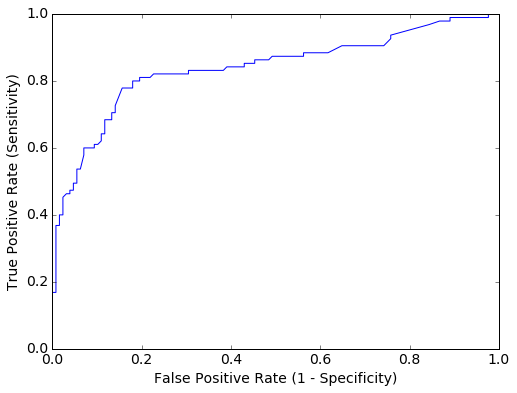

In [18]:
# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

In [19]:
# calculate AUC
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.838692434211


Besides allowing you to calculate AUC, seeing the ROC curve can help you to choose a threshold that **balances sensitivity and specificity** in a way that makes sense for the particular context.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd738779860>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fd7386fa860>], dtype=object)

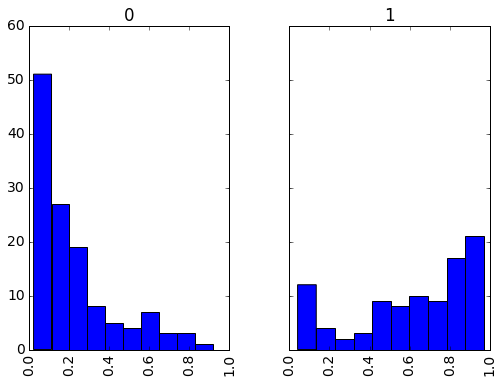

In [21]:
# histogram of predicted probabilities grouped by actual response value
df = pd.DataFrame({'probability':y_pred_prob, 'actual':y_test})
df.hist(column='probability', by='actual', sharex=True, sharey=True)

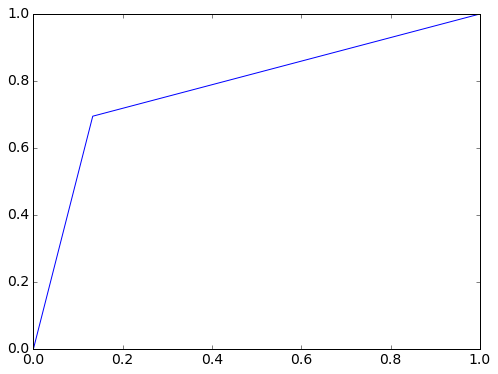

In [23]:
# ROC curve using y_pred_class - WRONG!
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_class)
plt.plot(fpr, tpr)

In [24]:
# AUC using y_pred_class - WRONG!
print(metrics.roc_auc_score(y_test, y_pred_class))

0.780962171053


If you use **y_pred_class**, it will interpret the zeros and ones as predicted probabilities of 0% and 100%.

# Cross-validation

## Review of model evaluation procedures

**Motivation:** Need a way to choose between machine learning models

- Goal is to estimate likely performance of a model on **out-of-sample data**

**Initial idea:** Train and test on the same data

- But, maximizing **training accuracy** rewards overly complex models which **overfit** the training data

**Alternative idea:** Train/test split

- Split the dataset into two pieces, so that the model can be trained and tested on **different data**
- **Testing accuracy** is a better estimate than training accuracy of out-of-sample performance
- But, it provides a **high variance** estimate since changing which observations happen to be in the testing set can significantly change testing accuracy

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics

# define X and y
feature_cols = ['Pclass', 'Parch', 'Age', 'Sex_Female', 'Embarked_Q', 'Embarked_S']
X = titanic[feature_cols]
y = titanic.Survived

In [27]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# train a logistic regression model
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

# make predictions for testing set
y_pred_class = logreg.predict(X_test)

# calculate testing accuracy
print(metrics.accuracy_score(y_test, y_pred_class))

0.793721973094


In [28]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# train a logistic regression model
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

# make predictions for testing set
y_pred_class = logreg.predict(X_test)

# calculate testing accuracy
print(metrics.accuracy_score(y_test, y_pred_class))

0.780269058296


In [29]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

# train a logistic regression model
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

# make predictions for testing set
y_pred_class = logreg.predict(X_test)

# calculate testing accuracy
print(metrics.accuracy_score(y_test, y_pred_class))

0.784753363229


train test spliting create bias due to the intrinsic randomness in the sets selection

# K-fold cross-validation

1. Split the dataset into K **equal** partitions (or "folds").
2. Use fold 1 as the **testing set** and the union of the other folds as the **training set**.
3. Calculate **testing accuracy**.
4. Repeat steps 2 and 3 K times, using a **different fold** as the testing set each time.
5. Use the **average testing accuracy** as the estimate of out-of-sample accuracy.



Diagram of **5-fold cross-validation:**

![5-fold cross-validation](https://raw.githubusercontent.com/justmarkham/DAT8/master/notebooks/images/cross_validation_diagram.png)

In [39]:
# simulate splitting a dataset of 25 observations into 5 folds
from sklearn.cross_validation import KFold
kf = KFold(25, n_folds=5, shuffle=False)

# print the contents of each training and testing set
print('{} {:^61} {}'.format('Iteration', 'Training set observations', 'Testing set observations'))
for iteration, data in enumerate(kf, start=1):
    print('{:^9} {} {:^25}'.format(str(iteration), str(data[0]), str(data[1])))

Iteration                   Training set observations                   Testing set observations
    1     [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]        [0 1 2 3 4]       
    2     [ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]        [5 6 7 8 9]       
    3     [ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19 20 21 22 23 24]     [10 11 12 13 14]     
    4     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 20 21 22 23 24]     [15 16 17 18 19]     
    5     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]     [20 21 22 23 24]     


- Dataset contains **25 observations** (numbered 0 through 24)
- 5-fold cross-validation, thus it runs for **5 iterations**
- For each iteration, every observation is either in the training set or the testing set, **but not both**
- Every observation is in the testing set **exactly once**

In [54]:
# Create k-folds
kf = KFold(X.shape[0], n_folds=10, random_state=0)

results = []

for train_index, test_index in kf:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # train a logistic regression model
    logreg = LogisticRegression(C=1e9)
    logreg.fit(X_train, y_train)

    # make predictions for testing set
    y_pred_class = logreg.predict(X_test)

    # calculate testing accuracy
    results.append(metrics.accuracy_score(y_test, y_pred_class))

In [60]:
pd.Series(results).describe()

count    10.000000
mean      0.794644
std       0.030631
min       0.764045
25%       0.768820
50%       0.780899
75%       0.820225
max       0.842697
dtype: float64

In [62]:
from sklearn.cross_validation import cross_val_score

logreg = LogisticRegression(C=1e9)

results = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')

In [63]:
pd.Series(results).describe()

count    10.000000
mean      0.794665
std       0.019263
min       0.775281
25%       0.779963
50%       0.786517
75%       0.806742
max       0.829545
dtype: float64

## Comparing cross-validation to train/test split

Advantages of **cross-validation:**

- More accurate estimate of out-of-sample accuracy
- More "efficient" use of data (every observation is used for both training and testing)

Advantages of **train/test split:**

- Runs K times faster than K-fold cross-validation
- Simpler to examine the detailed results of the testing process

## Cross-validation recommendations

1. K can be any number, but **K=10** is generally recommended
2. For classification problems, **stratified sampling** is recommended for creating the folds
    - Each response class should be represented with equal proportions in each of the K folds
    - scikit-learn's `cross_val_score` function does this by default

## Improvements to cross-validation

**Repeated cross-validation**

- Repeat cross-validation multiple times (with **different random splits** of the data) and average the results
- More reliable estimate of out-of-sample performance by **reducing the variance** associated with a single trial of cross-validation

**Creating a hold-out set**

- "Hold out" a portion of the data **before** beginning the model building process
- Locate the best model using cross-validation on the remaining data, and test it **using the hold-out set**
- More reliable estimate of out-of-sample performance since hold-out set is **truly out-of-sample**

**Feature engineering and selection within cross-validation iterations**

- Normally, feature engineering and selection occurs **before** cross-validation
- Instead, perform all feature engineering and selection **within each cross-validation iteration**
- More reliable estimate of out-of-sample performance since it **better mimics** the application of the model to out-of-sample data